## Parcel Clip

The parcel data we are working with is quite large, and therefore takes a very long time to load into notebooks. In order to more easily figure out our pipeline (without having to wait for it to load in each time), we will clip just to Alameda County (arbitrarily chosen -- it is simply the first observation).

We will then save this smaller geodataframe, and do the rest of our analysis (in other notebooks) with just Alameda County.

Alameda parquet file: w125_n40_w120_n35

In [1]:
import pandas as pd
from shapely.geometry import box
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import zipfile
import fiona

from sklearn.linear_model import LinearRegression

ERROR 1: PROJ: proj_create_from_database: Open of /Users/sarak/.conda/envs/electrigrid-env/share/proj failed


In [2]:
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

In [3]:
os.getcwd()

'/Users/sarak/MEDS/capstone/building-unit-regression'

In [53]:
# set option to see all data frame columns
pd.set_option('display.max_columns', None)

In [4]:
fiona.listlayers("data/Parcels_CA_2014.gdb")

['CA_PARCELS_STATEWIDE_INFO', 'CA_PARCELS_STATEWIDE']

In [6]:
parcels = gpd.read_file(
    "data/Parcels_CA_2014.gdb",
    layer="CA_PARCELS_STATEWIDE",
    where="County='Alameda'"
)

<Axes: >

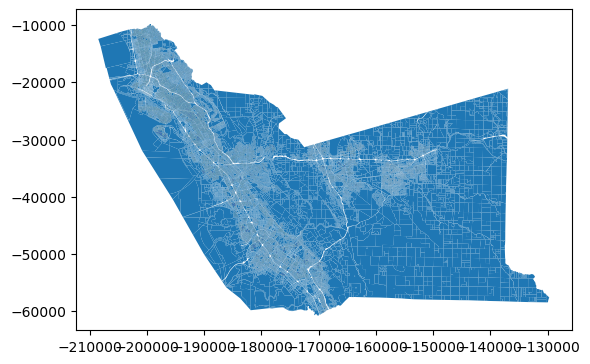

In [7]:
parcels.plot()

In [8]:
parcels = parcels.to_crs(epsg=4326)

In [10]:
fp = os.path.join('data', 'final_zillow.gpkg')
zillow = gpd.read_file(fp).to_crs(epsg=4326)

In [11]:
# specify tile download url; this url is for area containing Santa Barbara, CA
fp = os.path.join('data', 'building_parquets', 'w125_n40_w120_n35.parquet')

# read the parquet file into a DataFrame
building = gpd.read_parquet(fp).to_crs(epsg=4326)

In [12]:
# crop to residenetial parcels
valid_parcels = parcels.sjoin(zillow, predicate="contains").index.unique()
parcels_res = parcels.loc[valid_parcels]

In [13]:
# confirm that joining with Zillow decreased the number of parcels
print(f"Original parcel rows: {len(parcels)}")
print(f"Residential parcel rows: {len(parcels_res)}")
print(f"There are less residential parcels than total parcels: {len(parcels_res) < len(parcels)}")

Original parcel rows: 394597
Residential parcel rows: 342915
There are less residential parcels than total parcels: True


In [20]:
# crop to residential buildings
valid_buildings = building.sjoin(parcels_res, predicate="intersects").index.unique()
buildings_res = building.loc[valid_buildings]

In [22]:
# confirm that joining with Zillow decreased the number of parcels
print(f"Original building rows: {len(building)}")
print(f"Residential building rows: {len(buildings_res)}")
print(f"There are less residential parcels than total parcels: {len(buildings_res) < len(building)}")

Original building rows: 5108006
Residential building rows: 464004
There are less residential parcels than total parcels: True


In [ ]:
# makes kernel idle but would be nice to see!
buildings_res.plot()

In [29]:
# keep all residential buildings, and add zillow points only where they match up
building_zillow = gpd.sjoin(
    buildings_res,
    zillow,
    how = "left",
    predicate = "intersects")

In [30]:
# confirm that at least some buildings have Zillow data!
building_zillow[building_zillow['type']== 'Single'].head(3)

,source,id,height,var,region,bbox,geometry,index_right,type,year,...,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code
1172107,osm,519474311,7.800943,2.472754,USA,"{'xmin': -121.95481480000001, 'ymin': 37.71951...","POLYGON ((-121.95481 37.71965, -121.95478 37.7...",321530.0,Single,1988.0,...,I,1.0,1271914.0,living,2389.0,366731.0,06001450502,169,PGE/SCE,RR101
1172108,osm,519474309,5.384351,0.460701,USA,"{'xmin': -121.95421879999999, 'ymin': 37.71959...","POLYGON ((-121.95422 37.71975, -121.95422 37.7...",321532.0,Single,1988.0,...,I,1.0,787403.0,living,2052.0,366733.0,06001450502,169,PGE/SCE,RR101
1172109,osm,519474310,4.205719,0.737389,USA,"{'xmin': -121.9545191, 'ymin': 37.7195777, 'xm...","POLYGON ((-121.95452 37.71973, -121.95451 37.7...",321531.0,Single,1988.0,...,O,1.0,398112.0,living,2052.0,366732.0,06001450502,169,PGE/SCE,RR101


### Find volume information from building footprints

In [31]:
# reproject data frame to crs with meters as units
building_m = building_zillow.to_crs("EPSG:6933")

In [32]:
# find and create column from polygon area
building_m['area_m2'] = building_m.geometry.area

# rename height column to be clear about units
building_m.rename(columns={"height":"height_m"}, inplace = True)

building_m.head(2)

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,...,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2
1035189,osm,1305572434,6.357417,1.425106,USA,"{'xmin': -121.5639556, 'ymin': 37.793836599999...","POLYGON ((-11729233.298 4486927.121, -11729253...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698.442877
1035190,ms,UnitedStates_023010213_135375,5.767953,0.889574,USA,"{'xmin': -121.56371949738613, 'ymin': 37.79446...","POLYGON ((-11729226.719 4486961.910, -11729230...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.919586


In [33]:
# create volume column
building_m['volume_m3'] = building_m['area_m2'] * building_m['height_m']

building_m.head(2)

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,...,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2,volume_m3
1035189,osm,1305572434,6.357417,1.425106,USA,"{'xmin': -121.5639556, 'ymin': 37.793836599999...","POLYGON ((-11729233.298 4486927.121, -11729253...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698.442877,4440.292360
1035190,ms,UnitedStates_023010213_135375,5.767953,0.889574,USA,"{'xmin': -121.56371949738613, 'ymin': 37.79446...","POLYGON ((-11729226.719 4486961.910, -11729230...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.919586,120.663195


In [34]:
# explore number of rows that don't have unit data -- it's a lot
building_m['unit'].isna().sum()

208538

In [35]:
# keep only observations with unit data
building_w_units = building_m[~building_m['unit'].isna()]

# confirm operation worked
building_w_units['unit'].isna().sum()

0

<Axes: xlabel='volume_m3', ylabel='unit'>

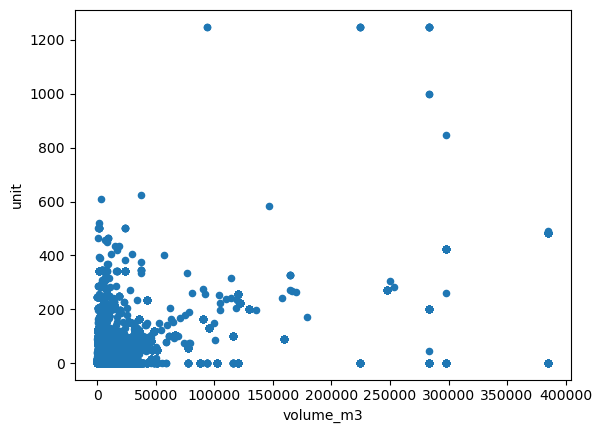

In [47]:
# plot units vs volume^3
building_w_units.plot(kind='scatter',
              x='volume_m3', 
              y='unit')

Next step: remove buildings that have a lot of units but no volume

In [42]:
# remove buildings with a volume of 0
building_w_units_1 = building_w_units[building_w_units['volume_m3'] != 0]

<Axes: xlabel='volume_m3', ylabel='unit'>

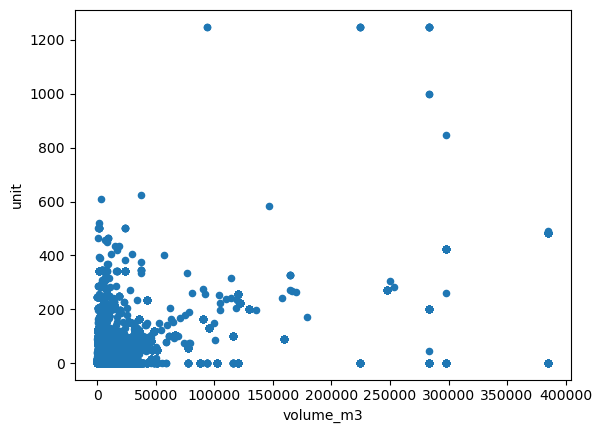

In [43]:
# plot units vs volume^3
building_w_units_1.plot(kind='scatter',
              x='volume_m3', 
              y='unit')

In [44]:
# x-values
x = np.array(building_w_units['volume_m3']).reshape((-1,1)) # Reshape to (n_samples, 1) ; -1 tells numpy that it can figure out how many rows we need
print(f"Input data shape: {x.shape}")

# y-values
y = np.array(building_w_units['unit'])
print(f"Output data shape: {y.shape}")

Input data shape: (299664, 1)
Output data shape: (299664,)


In [45]:
# Fit model
model = LinearRegression().fit(x, y)

In [48]:
R_sq = model.score(x,y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")

Coefficient of determination (R^2): 0.39617029396193637
x-axis intercept: 2.7432152359427975
Slope: 0.0010986369432096897


### Unit Prediction

In [57]:
# keep only multi-unit buildings (they are the only ones with missing data, anyway)
# BETTER TO DO THIS STEP BEFORE
building_multi = building_w_units[building_w_units['type'] == 'Multi']

building_multi.head()

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2,volume_m3,pred_units
1172292,osm,519477027,9.014627,1.452538,USA,"{'xmin': -121.94294729999996, 'ymin': 37.72242...","POLYGON ((-11765821.388 4479656.356, -11765816...",320660.0,Multi,1982.0,3.0,None,None,I,1.0,1119594.0,living,1885.0,365721.0,06001450502,169,PGE/SCE,RI101,232.149874,2092.744628,5.042382
1177921,osm,1107010162,5.895103,1.179340,USA,"{'xmin': -121.87884160000002, 'ymin': 37.73800...","POLYGON ((-11759626.255 4481234.348, -11759621...",382610.0,Multi,2018.0,4.0,None,None,I,2.0,1859606.0,living,4107.0,431626.0,06013355123,179,PGE/SCE,RI101,311.308066,1835.193104,4.759426
1178215,osm,552907644,7.042693,1.734722,USA,"{'xmin': -121.8753766, 'ymin': 37.722328699999...","POLYGON ((-11759301.742 4479656.153, -11759295...",355589.0,Multi,2006.0,4.0,None,None,O,1.0,372393.0,living,1272.0,402426.0,06001450102,179,PGE/SCE,RI110,77.113193,543.084552,3.339868
1178216,osm,552907643,7.042693,1.304207,USA,"{'xmin': -121.87530290000001, 'ymin': 37.72233...","POLYGON ((-11759294.631 4479656.721, -11759288...",355588.0,Multi,2006.0,4.0,None,None,O,1.0,273057.0,living,1272.0,402425.0,06001450102,179,PGE/SCE,RI110,77.941852,548.920543,3.346280
1178217,osm,552907641,6.935098,0.988388,USA,"{'xmin': -121.8751649, 'ymin': 37.722343499999...","POLYGON ((-11759274.524 4479658.546, -11759273...",355586.0,Multi,2006.0,4.0,None,None,O,1.0,397452.0,living,1272.0,402423.0,06001450102,179,PGE/SCE,RI110,83.464693,578.835841,3.379146


In [59]:
building_pred_units = building_multi.copy()

# Predict number of units for data without unit data using regression formula
building_pred_units['pred_units'] = building_multi['volume_m3'] * slope + intercept

In [60]:
building_pred_units.head()

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2,volume_m3,pred_units
1172292,osm,519477027,9.014627,1.452538,USA,"{'xmin': -121.94294729999996, 'ymin': 37.72242...","POLYGON ((-11765821.388 4479656.356, -11765816...",320660.0,Multi,1982.0,3.0,None,None,I,1.0,1119594.0,living,1885.0,365721.0,06001450502,169,PGE/SCE,RI101,232.149874,2092.744628,5.042382
1177921,osm,1107010162,5.895103,1.179340,USA,"{'xmin': -121.87884160000002, 'ymin': 37.73800...","POLYGON ((-11759626.255 4481234.348, -11759621...",382610.0,Multi,2018.0,4.0,None,None,I,2.0,1859606.0,living,4107.0,431626.0,06013355123,179,PGE/SCE,RI101,311.308066,1835.193104,4.759426
1178215,osm,552907644,7.042693,1.734722,USA,"{'xmin': -121.8753766, 'ymin': 37.722328699999...","POLYGON ((-11759301.742 4479656.153, -11759295...",355589.0,Multi,2006.0,4.0,None,None,O,1.0,372393.0,living,1272.0,402426.0,06001450102,179,PGE/SCE,RI110,77.113193,543.084552,3.339868
1178216,osm,552907643,7.042693,1.304207,USA,"{'xmin': -121.87530290000001, 'ymin': 37.72233...","POLYGON ((-11759294.631 4479656.721, -11759288...",355588.0,Multi,2006.0,4.0,None,None,O,1.0,273057.0,living,1272.0,402425.0,06001450102,179,PGE/SCE,RI110,77.941852,548.920543,3.346280
1178217,osm,552907641,6.935098,0.988388,USA,"{'xmin': -121.8751649, 'ymin': 37.722343499999...","POLYGON ((-11759274.524 4479658.546, -11759273...",355586.0,Multi,2006.0,4.0,None,None,O,1.0,397452.0,living,1272.0,402423.0,06001450102,179,PGE/SCE,RI110,83.464693,578.835841,3.379146


### Plot with points and regression line

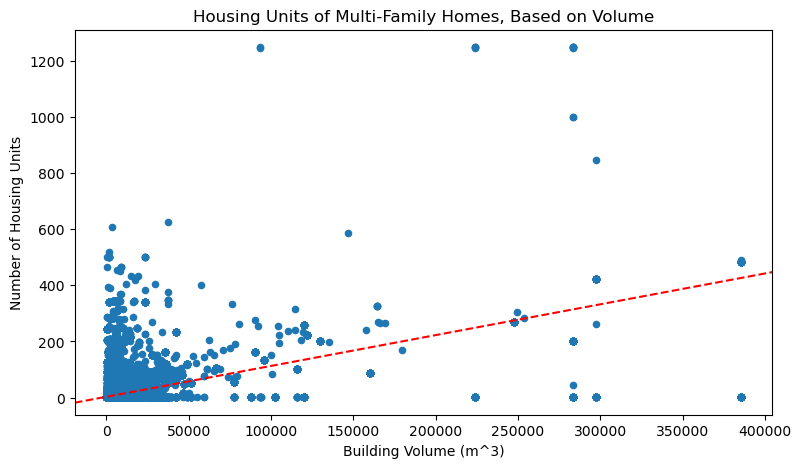

In [65]:
# preliminary plot

# initialize plot
fig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 1)

# plot building polygons
building_w_units.plot(ax =ax,
                      kind='scatter',
                      x='volume_m3', 
                      y='unit')

# plot zillow points
ax.axline(xy1=(0, intercept), slope=slope, color='r', linestyle='--', label=f'y = {slope}x + {intercept}')

plt.title("Housing Units of Multi-Family Homes, Based on Volume")
plt.xlabel("Building Volume (m^3)")
plt.ylabel("Number of Housing Units")
plt.show()